In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, context, unitsNumber = 64):
    features = concatenate([features, context])
    
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    dense_2 = Dense(unitsNumber, activation = 'elu')(dense_1_dropout)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)


dense_1 = Dense(512, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(512, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
    single_category_regressor(features, dense_2_dropout, 128),
])

output_layer = add([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21376/102124 [=====>........................] - ETA: 8:21 - loss: 4.1998 - acc: 0.6068

102112/102124 [============================>.] - ETA: 0s - loss: 1.2489 - acc: 0.8628

102124/102124 [==============================] - 636s 6ms/step - loss: 1.2487 - acc: 0.8628 - val_loss: 0.0818 - val_acc: 0.9740
Epoch 2/32
 10144/102124 [=>............................] - ETA: 8:52 - loss: 0.1002 - acc: 0.9712

102112/102124 [============================>.] - ETA: 0s - loss: 0.0913 - acc: 0.9726

102124/102124 [==============================] - 629s 6ms/step - loss: 0.0913 - acc: 0.9726 - val_loss: 0.1183 - val_acc: 0.9729
roc-auc: 0.94 - roc-auc_val: 0.9365                                                                                                    
Epoch 3/32
  8768/102124 [=>............................] - ETA: 8:56 - loss: 0.0778 - acc: 0.9745

102112/102124 [============================>.] - ETA: 0s - loss: 0.0704 - acc: 0.9762

102124/102124 [==============================] - 629s 6ms/step - loss: 0.0704 - acc: 0.9762 - val_loss: 0.0539 - val_acc: 0.9807
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 8:27 - loss: 0.0633 - acc: 0.9783

102112/102124 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9783

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0612 - acc: 0.9783 - val_loss: 0.1206 - val_acc: 0.9591
roc-auc: 0.9742 - roc-auc_val: 0.9723                                                                                                    
Epoch 5/32
  8736/102124 [=>............................] - ETA: 8:59 - loss: 0.0528 - acc: 0.9806

102112/102124 [============================>.] - ETA: 0s - loss: 0.0564 - acc: 0.9795

102124/102124 [==============================] - 628s 6ms/step - loss: 0.0564 - acc: 0.9795 - val_loss: 0.0549 - val_acc: 0.9800

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003298769879620522.
Epoch 6/32
  8064/102124 [=>............................] - ETA: 9:02 - loss: 0.0553 - acc: 0.9798

102112/102124 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9802

102124/102124 [==============================] - 628s 6ms/step - loss: 0.0530 - acc: 0.9802 - val_loss: 0.0475 - val_acc: 0.9817
roc-auc: 0.9866 - roc-auc_val: 0.9846                                                                                                    
Epoch 7/32
  8736/102124 [=>............................] - ETA: 8:59 - loss: 0.0511 - acc: 0.9805

102112/102124 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9808

102124/102124 [==============================] - 629s 6ms/step - loss: 0.0509 - acc: 0.9808 - val_loss: 0.0798 - val_acc: 0.9738
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 8:28 - loss: 0.0519 - acc: 0.9805

102112/102124 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9815

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0486 - acc: 0.9815 - val_loss: 0.0523 - val_acc: 0.9809
roc-auc: 0.9842 - roc-auc_val: 0.9809                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 8:58 - loss: 0.0485 - acc: 0.9815

102112/102124 [============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.9814

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0482 - acc: 0.9814 - val_loss: 0.1713 - val_acc: 0.9706
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 8:27 - loss: 0.0462 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9822

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0460 - acc: 0.9822 - val_loss: 0.1345 - val_acc: 0.9644
roc-auc: 0.9525 - roc-auc_val: 0.9488                                                                                                    
Epoch 11/32
  8704/102124 [=>............................] - ETA: 8:57 - loss: 0.0437 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0455 - acc: 0.9819

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0455 - acc: 0.9819 - val_loss: 0.0562 - val_acc: 0.9817
Epoch 12/32
 13984/102124 [===>..........................] - ETA: 8:26 - loss: 0.0435 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9820

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0451 - acc: 0.9820 - val_loss: 0.0457 - val_acc: 0.9834
roc-auc: 0.9904 - roc-auc_val: 0.9871                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 8:57 - loss: 0.0430 - acc: 0.9831

 63904/102124 [=================>............] - ETA: 3:40 - loss: 0.0442 - acc: 0.9828

102112/102124 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9830

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0440 - acc: 0.9830 - val_loss: 0.0433 - val_acc: 0.9839
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 8:27 - loss: 0.0412 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9834

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0430 - acc: 0.9834 - val_loss: 0.0764 - val_acc: 0.9785
roc-auc: 0.9748 - roc-auc_val: 0.9705                                                                                                    
Epoch 15/32
  8704/102124 [=>............................] - ETA: 8:59 - loss: 0.0416 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9835

102124/102124 [==============================] - 628s 6ms/step - loss: 0.0425 - acc: 0.9835 - val_loss: 0.0494 - val_acc: 0.9836
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 8:27 - loss: 0.0412 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9835

102124/102124 [==============================] - 628s 6ms/step - loss: 0.0420 - acc: 0.9835 - val_loss: 0.0411 - val_acc: 0.9829
roc-auc: 0.9923 - roc-auc_val: 0.9876                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 8:57 - loss: 0.0413 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9832

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0414 - acc: 0.9832 - val_loss: 0.0495 - val_acc: 0.9826
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 8:27 - loss: 0.0409 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9839

102124/102124 [==============================] - 628s 6ms/step - loss: 0.0408 - acc: 0.9839 - val_loss: 0.0438 - val_acc: 0.9831

Epoch 00018: ReduceLROnPlateau reducing learning rate to 8.53775127325207e-05.
roc-auc: 0.9918 - roc-auc_val: 0.9865                                                                                                    
Epoch 19/32
  5984/102124 [>.............................] - ETA: 9:12 - loss: 0.0414 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0404 - acc: 0.9841

102124/102124 [==============================] - 628s 6ms/step - loss: 0.0404 - acc: 0.9841 - val_loss: 0.0412 - val_acc: 0.9841
Epoch 20/32
 13984/102124 [===>..........................] - ETA: 8:29 - loss: 0.0394 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9840

102124/102124 [==============================] - 630s 6ms/step - loss: 0.0402 - acc: 0.9840 - val_loss: 0.0412 - val_acc: 0.9843
roc-auc: 0.9929 - roc-auc_val: 0.9873                                                                                                    
Epoch 21/32
  8672/102124 [=>............................] - ETA: 9:00 - loss: 0.0401 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9843

102124/102124 [==============================] - 627s 6ms/step - loss: 0.0397 - acc: 0.9843 - val_loss: 0.0415 - val_acc: 0.9838
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 8:25 - loss: 0.0407 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0395 - acc: 0.9844

102124/102124 [==============================] - 624s 6ms/step - loss: 0.0395 - acc: 0.9844 - val_loss: 0.0416 - val_acc: 0.9842
roc-auc: 0.9938 - roc-auc_val: 0.9864                                                                                                    
Epoch 23/32
  8704/102124 [=>............................] - ETA: 8:53 - loss: 0.0394 - acc: 0.9839

102112/102124 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9845

102124/102124 [==============================] - 623s 6ms/step - loss: 0.0388 - acc: 0.9845 - val_loss: 0.0417 - val_acc: 0.9842
Epoch 24/32
 13984/102124 [===>..........................] - ETA: 8:22 - loss: 0.0389 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9846

102124/102124 [==============================] - 621s 6ms/step - loss: 0.0385 - acc: 0.9846 - val_loss: 0.0420 - val_acc: 0.9838
roc-auc: 0.9934 - roc-auc_val: 0.9871                                                                                                    
Epoch 25/32
  8704/102124 [=>............................] - ETA: 8:52 - loss: 0.0360 - acc: 0.9854

102112/102124 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9845

102124/102124 [==============================] - 619s 6ms/step - loss: 0.0385 - acc: 0.9845 - val_loss: 0.0409 - val_acc: 0.9836
Epoch 26/32
 13984/102124 [===>..........................] - ETA: 8:20 - loss: 0.0370 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9843

102124/102124 [==============================] - 619s 6ms/step - loss: 0.0386 - acc: 0.9843 - val_loss: 0.0426 - val_acc: 0.9828
roc-auc: 0.9939 - roc-auc_val: 0.9868                                                                                                    
Epoch 27/32
  8704/102124 [=>............................] - ETA: 8:52 - loss: 0.0405 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9838

102124/102124 [==============================] - 619s 6ms/step - loss: 0.0383 - acc: 0.9838 - val_loss: 0.0415 - val_acc: 0.9827
Epoch 28/32
 13984/102124 [===>..........................] - ETA: 8:21 - loss: 0.0400 - acc: 0.9829

102112/102124 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9836

102124/102124 [==============================] - 617s 6ms/step - loss: 0.0382 - acc: 0.9835 - val_loss: 0.0413 - val_acc: 0.9827
roc-auc: 0.9926 - roc-auc_val: 0.9849                                                                                                    
Epoch 29/32
  8704/102124 [=>............................] - ETA: 8:50 - loss: 0.0385 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9837

102124/102124 [==============================] - 619s 6ms/step - loss: 0.0381 - acc: 0.9837 - val_loss: 0.0408 - val_acc: 0.9832

Epoch 00029: ReduceLROnPlateau reducing learning rate to 2.7204705475014634e-05.
Epoch 30/32
  8032/102124 [=>............................] - ETA: 8:55 - loss: 0.0379 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9839

102124/102124 [==============================] - 618s 6ms/step - loss: 0.0380 - acc: 0.9839 - val_loss: 0.0416 - val_acc: 0.9830
roc-auc: 0.9928 - roc-auc_val: 0.9867                                                                                                    
Epoch 31/32
  8704/102124 [=>............................] - ETA: 8:52 - loss: 0.0380 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9843

102124/102124 [==============================] - 617s 6ms/step - loss: 0.0377 - acc: 0.9843 - val_loss: 0.0498 - val_acc: 0.9826
Epoch 32/32
 13984/102124 [===>..........................] - ETA: 8:19 - loss: 0.0371 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9842

102124/102124 [==============================] - 616s 6ms/step - loss: 0.0375 - acc: 0.9842 - val_loss: 0.0408 - val_acc: 0.9836
roc-auc: 0.9943 - roc-auc_val: 0.9871                                                                                                    


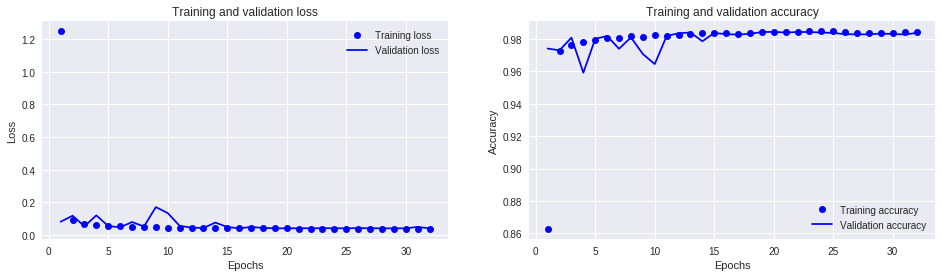

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 52s 2ms/step
([0.039214009619822056, 0.9838477080413284], 0.9887661205037759)
